# Analysis of Twitter the-algorithm source code with LangChain, GPT4 and Deep Lake
In this tutorial, we are going to use Langchain + Deep Lake with GPT4 to analyze the code base of the twitter algorithm. 

Define OpenAI embeddings, Deep Lake multi-modal vector store api and authenticate. For full documentation of Deep Lake please follow [docs](https://docs.activeloop.ai/) and [API reference](https://docs.deeplake.ai/en/latest/).

Authenticate into Deep Lake if you want to create your own dataset and publish it. You can get an API key from the [platform](https://app.activeloop.ai)

In [4]:
import re

In [ ]:
TRANSFORMERS_CACHE="/f/C/cache/huggingface/hub"

In [1]:
import os
import tqdm as notebook_tqdm
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import DeepLake

os.environ['TRANSFORMERS_CACHE'] = 'F:\C\cache\huggingface\hub'
os.environ['ACTIVELOOP_TOKEN'] = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

Load all files inside the repository

In [2]:
from langchain.document_loaders import PyPDFLoader
import tiktoken

root_dir = '../sources-repositories/langchain'  # Declare root directory variable
docs = []  # Create empty list for documents

pdf_loader = PyPDFLoader('..sources-documents/Talks-with-Sri-Ramana-Maharshi--complete.pdf')  # Use PDFLoader to load and split the PDF file's content
docs.extend(pdf_loader.load()) # just load, don't split

In [5]:
len(docs) # number of processed document pages
print(docs[40]) # returns 31Talks with Sri Ramana Maharshi\n(a) Is omniscience of God consis ....

# Use regex to remove "31Talks with Sri Ramana Maharshi\n"
pg_40 =
print(pg_40)

page_content='31Talks with Sri Ramana Maharshi\n(a) Is omniscience of God consistent with ego’s freewill?\n(b) Is omnipotence of God consistent with ego’s freewill?\n(c) Are the natural laws consistent with God’s free-will?\nM.: Yes. Free-will is the present appearing to a limited faculty of \nsight and will. The same ego sees its past activity as falling into a \ncourse of ‘law’ or rules - its own free-will being one of the links \nin that course of law.\nOmnipotence and omniscience of God are then seen by the ego to \nhave acted through the appearance of his own free-will. So he comes \nto the conclusion that the ego must go by appearances. Natural laws \nare manifestations of God’s will and they have been laid down.\nD.: Is the study of science, psychology, physiology, philosophy, etc. \nhelpful for:-\n(1) this art of yoga-liberation.\n(2) the intuitive grasp of the unity of the Real?\nM.: Very little. Some knowledge is needed for yoga and it may be \nfound in books. But practical a

TypeError: expected string or bytes-like object

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

# Visualizing Token Length in Docs

Min: 0
Avg: 490
Max: 812


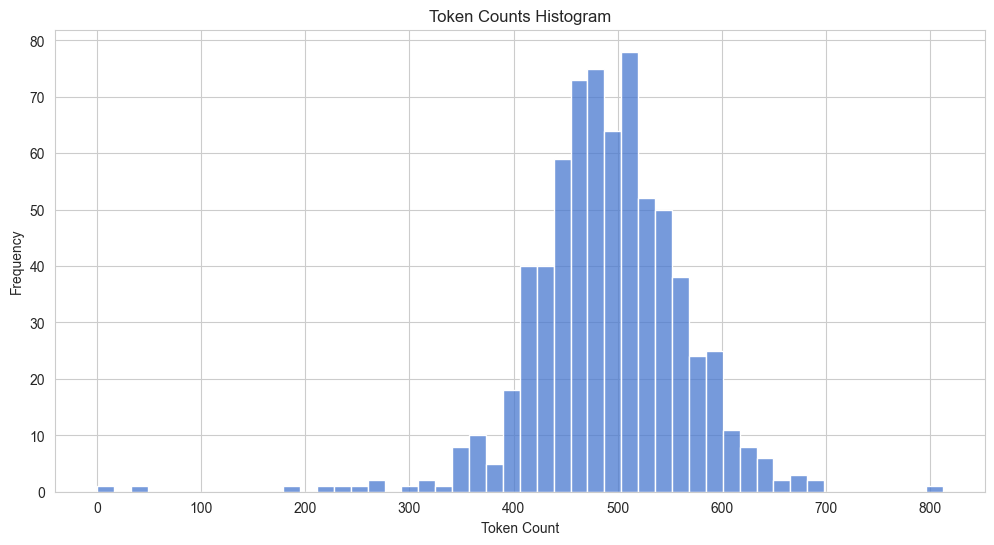

In [6]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

Then, chunk the files

## New Chunking method

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [14]:
print(docs[25])

page_content='16Talks with Sri Ramana Maharshi\nD.: They say that there are many saints in Tibet who remain in solitude \nand are still very helpful to the world. How can it be?\nM.: It can be so. Realisation of the Self is the greatest help that can be \nrendered to humanity. Therefore, the saints are said to be helpful, \nthough they remain in forests. But it should not be forgotten that \nsolitude is not in forests only. It can be had even in towns, in the \nthick of worldly occupations.\nD.: It is not necessary that the saints should mix with people and be \nhelpful to them?\nM.: The Self alone is the Reality; the world and the rest of it are not. The \nrealised being does not see the world as different from himself.\nD.: Thus then, the saint’s realisation leads to the uplift of humanity \nwithout the latter being aware of it. Is it so?\nM.: Yes. The help is imperceptible but is still there. A saint helps the \nwhole of humanity, unknown to the latter.\nD.: Would it not be better i

In [10]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

from tqdm.auto import tqdm
from langchain.docstore.document import Document
documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('../dev/langchain/langchain\\', 'https://github.com/hwchase17/langchain/tree/master/langchain/')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append(
            Document(
                page_content=re.sub(r'\d{1,3}Talks with Sri Ramana Maharshi\n', '', chunk),
                metadata={
                    'id': f'{uid}-{i}',
                    'source': url
                }
            )
        )
            # {'text': chunk})
        # documents.append({
        #     'id': f'{uid}-{i}',
        #     'text': chunk,
        #     'source': url
        # })
        # documents.extend(f"id={uid}-{i}")
        # documents.extend('text={chunk}')
        # documents.extend('source={url}')


  0%|          | 0/704 [00:00<?, ?it/s]

In [15]:
len(documents)
print(docs[25])

page_content='16Talks with Sri Ramana Maharshi\nD.: They say that there are many saints in Tibet who remain in solitude \nand are still very helpful to the world. How can it be?\nM.: It can be so. Realisation of the Self is the greatest help that can be \nrendered to humanity. Therefore, the saints are said to be helpful, \nthough they remain in forests. But it should not be forgotten that \nsolitude is not in forests only. It can be had even in towns, in the \nthick of worldly occupations.\nD.: It is not necessary that the saints should mix with people and be \nhelpful to them?\nM.: The Self alone is the Reality; the world and the rest of it are not. The \nrealised being does not see the world as different from himself.\nD.: Thus then, the saint’s realisation leads to the uplift of humanity \nwithout the latter being aware of it. Is it so?\nM.: Yes. The help is imperceptible but is still there. A saint helps the \nwhole of humanity, unknown to the latter.\nD.: Would it not be better i

page_content='"""Beta Feature: base interface for cache."""\nimport json\nfrom abc import ABC, abstractmethod\nfrom typing import Any, Callable, Dict, List, Optional, Tuple\n\nfrom sqlalchemy import Column, Integer, String, create_engine, select\nfrom sqlalchemy.engine.base import Engine\nfrom sqlalchemy.orm import Session\n\ntry:\n    from sqlalchemy.orm import declarative_base\nexcept ImportError:\n    from sqlalchemy.ext.declarative import declarative_base\n\nfrom langchain.schema import Generation\n\nRETURN_VAL_TYPE = List[Generation]\n\n\nclass BaseCache(ABC):\n    """Base interface for cache."""\n\n    @abstractmethod\n    def lookup(self, prompt: str, llm_string: str) -> Optional[RETURN_VAL_TYPE]:\n        """Look up based on prompt and llm_string."""\n\n    @abstractmethod\n    def update(self, prompt: str, llm_string: str, return_val: RETURN_VAL_TYPE) -> None:\n        """Update cache based on prompt and llm_string."""\n\n\nclass InMemoryCache(BaseCache):\n    """Cache that st

Execute the indexing. This will take about ~4 mins to compute embeddings and upload to Activeloop. You can then publish the dataset to be public.

# Vector Storage

In [132]:
database_name = "langchain_v2"

content_source = documents
# content_source = text   # Old chunking method

## Create database

### Local vector store

Stored in RAM

In [133]:
import deeplake
db = DeepLake.from_documents(content_source, embeddings, dataset_path=f"mem://{database_name}")

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0


mem://langchain_v2 loaded successfully.


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
Evaluating ingest: 0%|          | 0/2 [00:00<?

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
Evaluating ingest: 50%|█████     | 1/2 [00:21<00:21

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating ingest: 100%|██████████| 2/2 [00:32<00:00
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0


Dataset(path='mem://langchain_v2', tensors=['embedding', 'ids', 'metadata', 'text'])

  tensor     htype      shape      dtype  compression
  -------   -------    -------    -------  ------- 
 embedding  generic  (1352, 768)  float32   None   
    ids      text     (1352, 1)     str     None   
 metadata    json     (1352, 1)     str     None   
   text      text     (1352, 1)     str     None   


### Remote storage

Uses Activeloop API

In [ ]:
os.environ['ACTIVELOOP_TOKEN'] = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
db = DeepLake.from_documents(content_source, embeddings, dataset_path=f"hub://deadbranches/{database_name}")

## Data Retrieval

Local

In [ ]:
db = DeepLake(dataset_path=f"mem://{database_name}", read_only=True, embedding_function=embeddings)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0


mem://langchain_v2 loaded successfully.


DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443


DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): spire.bugout.dev:443
DEBUG:urllib3.connectionpool:https://spire.bugout.dev:443 "POST /humbug/reports HTTP/1.1" 200 0


test

Remote

In [ ]:
db = DeepLake(dataset_path=f"hub://deadbranches/{database_name}", read_only=True, embedding_function=embeddings)

## Visualize data

### 2. Question Answering on Twitter algorithm codebase
First load the dataset, construct the retriever, then construct the Conversational Chain

In [129]:

retriever = db.as_retriever()
retriever.search_kwargs['distance_metric'] = 'dot'
retriever.search_kwargs['fetch_k'] = 100
retriever.search_kwargs['maximal_marginal_relevance'] = True
retriever.search_kwargs['k'] = 20

In [187]:
query = """
What other methods can I use to search a vector database other than similarity_search?
"""
results = db.similarity_search(query, distance_metric='dot', k=4)

# print("class:", type(results).__name__)
for result in results:
    print(f"Source:  {result.metadata['source']} ")
    print("\nContent:  ")
    page_content = json.dumps(result.page_content).replace('\\n', '\n').replace('\\"', '"')
    print(page_content)
    print("\n\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Source:  https://github.com/hwchase17/langchain/tree/master/langchain/chains\qa_with_sources\map_reduce_prompt.py 

Content:  
"QUESTION: Which state/country's law governs the interpretation of the contract?
Content: This Agreement is governed by English law and the parties submit to the exclusive jurisdiction of the English courts in  relation to any dispute (contractual or non-contractual) concerning this Agreement save that either party may apply to any court for an  injunction or other relief to protect its Intellectual Property Rights.
Source: 28-pl
Content: No Waiver. Failure or delay in exercising any right or remedy under this Agreement shall not constitute a waiver of such (or any other)  right or remedy.\
\
11.7 Severability. The invalidity, illegality or unenforceability of any term (or part of a term) of this Agreement shall not affect the continuation  in force of the remainder of the term (if any) and this Agreement.\
\
11.8 No Agency. Except as expressly stated otherwise

You can also specify user defined functions using [Deep Lake filters](https://docs.deeplake.ai/en/latest/deeplake.core.dataset.html#deeplake.core.dataset.Dataset.filter)

In [15]:
def filter(x):
    # filter based on source code
    # if 'com.google' in x['text'].data()['value']:
    #     return False
    
    # filter based on path e.g. extension
    metadata =  x['metadata'].data()['value']
    return 'scala' in metadata['source'] or 'py' in metadata['source']

### turn on below for custom filtering
# retriever.search_kwargs['filter'] = filter

In [23]:
os.environ['OPENAI_API_KEY'] = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

import logging

logging.basicConfig(level=logging.DEBUG)

#model = ChatOpenAI(model='gpt-4') # 'gpt-3.5-turbo',
model = ChatOpenAI(model='gpt-3.5-turbo') # 'gpt-3.5-turbo',
qa = ConversationalRetrievalChain.from_llm(model,retriever=retriever)

In [25]:
questions = [
    "How do I load a 4bit quantized LLaMA model into langchain for inference tasks? The model was quantized using GPTQ, and has a group size of 128?",
] 
chat_history = []

# for question in questions:  
#     result = qa({"question": question, "chat_history": chat_history})
#     print(result)

for question in questions:  
    result = qa({"question": question, "chat_history": chat_history})
    chat_history.append((question, result['answer']))
    print(f"-> **Question**: {question} \n")
    print(f"**Answer**: {result['answer']} \n")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "Use the following pieces of context to answer the users question. \\nIf you don\'t know the answer, just say that you don\'t know, don\'t try to make up an answer.\\n----------------\\nHourly Parameter Definition\\nThe parameter &hourly= accepts the following values. Most weather variables are given as an instantaneous value for the indicated hour. Some variables like precipitation are calculated from the preceding hour as an average or sum.\\n\\nHourly Parameter Definition\\nThe parameter &hourly= accepts the following values. Most weather variables are given as an instantaneous value for the indicated hour. Some variables like precipitation are calculated from the preceding hour as an average or sum.\\n\\ndef _default_scripting_text_mapping(\\n    dim: int,\\n    vector_field: str = \\"vector_field\\"

-> **Question**: How do I load a 4bit quantized LLaMA model into langchain for inference tasks? The model was quantized using GPTQ, and has a group size of 128? 

**Answer**: I'm sorry, but I am not familiar with the Langchain framework or with the GPTQ quantization method. Without more information, I cannot provide an accurate answer to your question. Can you provide more details or context about what you are trying to do? 



-> **Question**: What does favCountParams do? 

**Answer**: `favCountParams` is an optional ThriftLinearFeatureRankingParams instance that represents the parameters related to the "favorite count" feature in the ranking process. It is used to control the weight of the favorite count feature while ranking tweets. The favorite count is the number of times a tweet has been marked as a favorite by users, and it is considered an important signal in the ranking of tweets. By using `favCountParams`, the system can adjust the importance of the favorite count while calculating the final ranking score of a tweet. 

-> **Question**: is it Likes + Bookmarks, or not clear from the code?

**Answer**: From the provided code, it is not clear if the favorite count metric is determined by the sum of likes and bookmarks. The favorite count is mentioned in the code, but there is no explicit reference to how it is calculated in terms of likes and bookmarks. 

-> **Question**: What are the major negative modifiers that lower your linear ranking parameters?

**Answer**: In the given code, major negative modifiers that lower the linear ranking parameters are:

1. `scoringData.querySpecificScore`: This score adjustment is based on the query-specific information. If its value is negative, it will lower the linear ranking parameters.

2. `scoringData.authorSpecificScore`: This score adjustment is based on the author-specific information. If its value is negative, it will also lower the linear ranking parameters.

Please note that I cannot provide more information on the exact calculations of these negative modifiers, as the code for their determination is not provided. 

-> **Question**: How do you get assigned to SimClusters?

**Answer**: The assignment to SimClusters occurs through a Metropolis-Hastings sampling-based community detection algorithm that is run on the Producer-Producer similarity graph. This graph is created by computing the cosine similarity scores between the users who follow each producer. The algorithm identifies communities or clusters of Producers with similar followers, and takes a parameter *k* for specifying the number of communities to be detected.

After the community detection, different users and content are represented as sparse, interpretable vectors within these identified communities (SimClusters). The resulting SimClusters embeddings can be used for various recommendation tasks. 

-> **Question**: What is needed to migrate from one SimClusters to another SimClusters?

**Answer**: To migrate from one SimClusters representation to another, you can follow these general steps:

1. **Prepare the new representation**: Create the new SimClusters representation using any necessary updates or changes in the clustering algorithm, similarity measures, or other model parameters. Ensure that this new representation is properly stored and indexed as needed.

2. **Update the relevant code and configurations**: Modify the relevant code and configuration files to reference the new SimClusters representation. This may involve updating paths or dataset names to point to the new representation, as well as changing code to use the new clustering method or similarity functions if applicable.

3. **Test the new representation**: Before deploying the changes to production, thoroughly test the new SimClusters representation to ensure its effectiveness and stability. This may involve running offline jobs like candidate generation and label candidates, validating the output, as well as testing the new representation in the evaluation environment using evaluation tools like TweetSimilarityEvaluationAdhocApp.

4. **Deploy the changes**: Once the new representation has been tested and validated, deploy the changes to production. This may involve creating a zip file, uploading it to the packer, and then scheduling it with Aurora. Be sure to monitor the system to ensure a smooth transition between representations and verify that the new representation is being used in recommendations as expected.

5. **Monitor and assess the new representation**: After the new representation has been deployed, continue to monitor its performance and impact on recommendations. Take note of any improvements or issues that arise and be prepared to iterate on the new representation if needed. Always ensure that the results and performance metrics align with the system's goals and objectives. 

-> **Question**: How much do I get boosted within my cluster?

**Answer**: It's not possible to determine the exact amount your content is boosted within your cluster in the SimClusters representation without specific data about your content and its engagement metrics. However, a combination of factors, such as the favorite score and follow score, alongside other engagement signals and SimCluster calculations, influence the boosting of content. 

-> **Question**: How does Heavy ranker work. what are it’s main inputs?

**Answer**: The Heavy Ranker is a machine learning model that plays a crucial role in ranking and scoring candidates within the recommendation algorithm. Its primary purpose is to predict the likelihood of a user engaging with a tweet or connecting with another user on the platform.

Main inputs to the Heavy Ranker consist of:

1. Static Features: These are features that can be computed directly from a tweet at the time it's created, such as whether it has a URL, has cards, has quotes, etc. These features are produced by the Index Ingester as the tweets are generated and stored in the index.

2. Real-time Features: These per-tweet features can change after the tweet has been indexed. They mostly consist of social engagements like retweet count, favorite count, reply count, and some spam signals that are computed with later activities. The Signal Ingester, which is part of a Heron topology, processes multiple event streams to collect and compute these real-time features.

3. User Table Features: These per-user features are obtained from the User Table Updater that processes a stream written by the user service. This input is used to store sparse real-time user information, which is later propagated to the tweet being scored by looking up the author of the tweet.

4. Search Context Features: These features represent the context of the current searcher, like their UI language, their content consumption, and the current time (implied). They are combined with Tweet Data to compute some of the features used in scoring.

These inputs are then processed by the Heavy Ranker to score and rank candidates based on their relevance and likelihood of engagement by the user. 

-> **Question**: How can one influence Heavy ranker?

**Answer**: To influence the Heavy Ranker's output or ranking of content, consider the following actions:

1. Improve content quality: Create high-quality and engaging content that is relevant, informative, and valuable to users. High-quality content is more likely to receive positive user engagement, which the Heavy Ranker considers when ranking content.

2. Increase user engagement: Encourage users to interact with content through likes, retweets, replies, and comments. Higher engagement levels can lead to better ranking in the Heavy Ranker's output.

3. Optimize your user profile: A user's reputation, based on factors such as their follower count and follower-to-following ratio, may impact the ranking of their content. Maintain a good reputation by following relevant users, keeping a reasonable follower-to-following ratio and engaging with your followers.

4. Enhance content discoverability: Use relevant keywords, hashtags, and mentions in your tweets, making it easier for users to find and engage with your content. This increased discoverability may help improve the ranking of your content by the Heavy Ranker.

5. Leverage multimedia content: Experiment with different content formats, such as videos, images, and GIFs, which may capture users' attention and increase engagement, resulting in better ranking by the Heavy Ranker.

6. User feedback: Monitor and respond to feedback for your content. Positive feedback may improve your ranking, while negative feedback provides an opportunity to learn and improve.

Note that the Heavy Ranker uses a combination of machine learning models and various features to rank the content. While the above actions may help influence the ranking, there are no guarantees as the ranking process is determined by a complex algorithm, which evolves over time. 

-> **Question**: why threads and long tweets do so well on the platform?

**Answer**: Threads and long tweets perform well on the platform for several reasons:

1. **More content and context**: Threads and long tweets provide more information and context about a topic, which can make the content more engaging and informative for users. People tend to appreciate a well-structured and detailed explanation of a subject or a story, and threads and long tweets can do that effectively.

2. **Increased user engagement**: As threads and long tweets provide more content, they also encourage users to engage with the tweets through replies, retweets, and likes. This increased engagement can lead to better visibility of the content, as the Twitter algorithm considers user engagement when ranking and surfacing tweets.

3. **Narrative structure**: Threads enable users to tell stories or present arguments in a step-by-step manner, making the information more accessible and easier to follow. This narrative structure can capture users' attention and encourage them to read through the entire thread and interact with the content.

4. **Expanded reach**: When users engage with a thread, their interactions can bring the content to the attention of their followers, helping to expand the reach of the thread. This increased visibility can lead to more interactions and higher performance for the threaded tweets.

5. **Higher content quality**: Generally, threads and long tweets require more thought and effort to create, which may lead to higher quality content. Users are more likely to appreciate and interact with high-quality, well-reasoned content, further improving the performance of these tweets within the platform.

Overall, threads and long tweets perform well on Twitter because they encourage user engagement and provide a richer, more informative experience that users find valuable. 

-> **Question**: Are thread and long tweet creators building a following that reacts to only threads?

**Answer**: Based on the provided code and context, there isn't enough information to conclude if the creators of threads and long tweets primarily build a following that engages with only thread-based content. The code provided is focused on Twitter's recommendation and ranking algorithms, as well as infrastructure components like Kafka, partitions, and the Follow Recommendations Service (FRS). To answer your question, data analysis of user engagement and results of specific edge cases would be required. 

-> **Question**: Do you need to follow different strategies to get most followers vs to get most likes and bookmarks per tweet?

**Answer**: Yes, different strategies need to be followed to maximize the number of followers compared to maximizing likes and bookmarks per tweet. While there may be some overlap in the approaches, they target different aspects of user engagement.

Maximizing followers: The primary focus is on growing your audience on the platform. Strategies include:

1. Consistently sharing high-quality content related to your niche or industry.
2. Engaging with others on the platform by replying, retweeting, and mentioning other users.
3. Using relevant hashtags and participating in trending conversations.
4. Collaborating with influencers and other users with a large following.
5. Posting at optimal times when your target audience is most active.
6. Optimizing your profile by using a clear profile picture, catchy bio, and relevant links.

Maximizing likes and bookmarks per tweet: The focus is on creating content that resonates with your existing audience and encourages engagement. Strategies include:

1. Crafting engaging and well-written tweets that encourage users to like or save them.
2. Incorporating visually appealing elements, such as images, GIFs, or videos, that capture attention.
3. Asking questions, sharing opinions, or sparking conversations that encourage users to engage with your tweets.
4. Using analytics to understand the type of content that resonates with your audience and tailoring your tweets accordingly.
5. Posting a mix of educational, entertaining, and promotional content to maintain variety and interest.
6. Timing your tweets strategically to maximize engagement, likes, and bookmarks per tweet.

Both strategies can overlap, and you may need to adapt your approach by understanding your target audience's preferences and analyzing your account's performance. However, it's essential to recognize that maximizing followers and maximizing likes and bookmarks per tweet have different focuses and require specific strategies. 

-> **Question**: Content meta data and how it impacts virality (e.g. ALT in images).

**Answer**: There is no direct information in the provided context about how content metadata, such as ALT text in images, impacts the virality of a tweet or post. However, it's worth noting that including ALT text can improve the accessibility of your content for users who rely on screen readers, which may lead to increased engagement for a broader audience. Additionally, metadata can be used in search engine optimization, which might improve the visibility of the content, but the context provided does not mention any specific correlation with virality. 

-> **Question**: What are some unexpected fingerprints for spam factors?

**Answer**: In the provided context, an unusual indicator of spam factors is when a tweet contains a non-media, non-news link. If the tweet has a link but does not have an image URL, video URL, or news URL, it is considered a potential spam vector, and a threshold for user reputation (tweepCredThreshold) is set to MIN_TWEEPCRED_WITH_LINK.

While this rule may not cover all possible unusual spam indicators, it is derived from the specific codebase and logic shared in the context. 

-> **Question**: Is there any difference between company verified checkmarks and blue verified individual checkmarks?

**Answer**: Yes, there is a distinction between the verified checkmarks for companies and blue verified checkmarks for individuals. The code snippet provided mentions "Blue-verified account boost" which indicates that there is a separate category for blue verified accounts. Typically, blue verified checkmarks are used to indicate notable individuals, while verified checkmarks are for companies or organizations. 
